# mlp reimplementation

Reproducing https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Code written while following along with: https://www.youtube.com/watch?v=TCH_1BHY58I

In [190]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
import string

stoi = {ch: i+1 for i, ch in enumerate(string.ascii_lowercase)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [192]:
words = open('data/names.txt', 'r').read().splitlines()

In [193]:
words[:8]
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [194]:
# This is n in the paper, the size of the "context" or look-back window
block_size = n = 3

# Create the dataset, where the inputs are a trigram context window -> outputs are the next character
X, Y = [], []

for w in words[:5]:
    print(w)
    w = w + '.'
    context = [0] * block_size
    for char in list(w):
        X.append(context)
        Y.append(stoi[char])

        context_str = ''.join(itos[v] for v in context)
        print(f'{context_str} ---> {char}')
        context = context[1:] + [stoi[char]]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [195]:
# Hyperparameters
m_dim = 2 # Num of features for each tri-gram embedding to learn
v = 27    # possible characters, the vocabulary size
h = 128    # Number of neurons in hidden layer

In [196]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [197]:
# Embedding each character to 2-dimensional feature space
C = torch.rand((v, m_dim), requires_grad=True)
C

tensor([[8.0462e-01, 1.5518e-01],
        [2.4626e-01, 8.9149e-01],
        [9.3496e-04, 1.1522e-01],
        [6.4226e-01, 4.2484e-01],
        [3.2724e-01, 2.1300e-01],
        [4.0775e-01, 5.9286e-01],
        [3.9953e-04, 8.2746e-01],
        [1.5281e-01, 2.2578e-01],
        [1.3334e-01, 9.5502e-01],
        [2.1844e-01, 3.3758e-01],
        [3.5089e-01, 3.2088e-01],
        [1.2705e-02, 1.1382e-02],
        [9.6287e-01, 8.0430e-01],
        [1.0194e-01, 6.3912e-01],
        [5.6108e-01, 4.7525e-01],
        [2.7224e-01, 8.9344e-01],
        [6.0283e-01, 6.7684e-01],
        [6.8316e-01, 5.5188e-01],
        [7.3333e-01, 9.1147e-01],
        [2.6761e-01, 5.6548e-01],
        [1.6250e-01, 5.6767e-01],
        [2.2849e-01, 8.4969e-01],
        [4.2668e-01, 3.3682e-01],
        [4.3616e-01, 1.9750e-01],
        [4.6645e-01, 4.3366e-01],
        [9.2169e-01, 3.4697e-01],
        [3.7402e-01, 3.6730e-01]], requires_grad=True)

In [198]:
C[X].shape

torch.Size([32, 3, 2])

In [199]:
embedding = C[X]
embedding.shape

torch.Size([32, 3, 2])

In [200]:
# Hidden layer weights
W1 = torch.randn((block_size*m_dim, h), requires_grad=True)
b1 = torch.randn(h, requires_grad=True)
W1.shape, b1.shape

(torch.Size([6, 128]), torch.Size([128]))

In [201]:
# Several ways to get the right dimension we want...
a = embedding.reshape((32, block_size*m_dim))
b = torch.cat([embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]], 1)
c = torch.cat(torch.unbind(embedding, 1), 1)
# View is the most effecient because it utilizes underlying storage and doesn't do a copy
d = embedding.view((32, block_size*m_dim))

print(torch.equal(a, b))
print(torch.equal(b, c))
print(torch.equal(b, d))

True
True
True


In [202]:
# 32x6 @ 6x128
z1 = F.relu(embedding.view((32, block_size*m_dim)) @ W1 + b1)
z1.shape

torch.Size([32, 128])

In [203]:
W2 = torch.randn((h, v), requires_grad=True)
b2 = torch.randn(v, requires_grad=True)

# (examples, h) @ (h, v) = (examples, v) + v
z2 = F.softmax(z1 @ W2 + b2, dim=1)

# Manual softmax works too
logits = z1 @ W2 + b2
counts = logits.exp()
out = counts / counts.sum(dim=1, keepdim=True)
assert torch.allclose(out, z2)

In [204]:
loss = -z2[torch.arange(32), Y].log().mean() + (0.01*(W1**2).mean())
loss.backward()

In [205]:
learning_rate = 0.1

for params in [C, W1, b1, W2, b2]:
    params.data += learning_rate * params.grad

# Cleanup and make a training loop

In [206]:
#### Hyperparameters

# Num of features for each tri-gram embedding to learn
m_dim = 2

# possible characters, the vocabulary size, this isn't actually tuneable as its len(alphas) + 1 for delimiter
v = 27

# Number of neurons in hidden layer
h = 128

# This is n in the paper, the size of the "context" or look-back window
block_size = n = 3

In [221]:
#### Data prep

def build_dataset(in_words):
    # Create the dataset, where the inputs are a trigram context window -> outputs are the next character
    X, Y = [], []
    
    for w in in_words:
        w = w + '.'
        context = [0] * block_size
        for char in list(w):
            X.append(context)
            Y.append(stoi[char])
            context = context[1:] + [stoi[char]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [222]:
#### Parameter initialization

# Embedding each character to 2-dimensional feature space
C = torch.rand((v, m_dim), requires_grad=True)

# Hidden layer weights and biases
W1 = torch.randn((block_size*m_dim, h), requires_grad=True)
b1 = torch.randn(h, requires_grad=True)

# Output layer weights and biases
W2 = torch.randn((h, v), requires_grad=True)
b2 = torch.randn(v, requires_grad=True)

In [210]:
C.shape

torch.Size([27, 2])

In [415]:
# Training loop
batch_size = 32

stepi = []
lossi = []
dead_neurons = []

for i in range(200000):
    # minibatch
    # select batch_size random indices from the training data
    idxs = torch.randint(0, X_train.shape[0], (batch_size,))
    idx = X_train[idxs]

    # Forwards pass
    embedding = C[idx]
    # Lots of dead neurons when using ReLU, but turns out this wasn't the issue causing
    # bad performance at first. Seems to work with tanh/leaky_ReLU/ReLU all the same.
    z1 = F.relu(embedding.view(-1, block_size*m_dim) @ W1 + b1) # (batch_size, h)
    #z1 = F.leaky_relu(embedding.view(-1, block_size*m_dim) @ W1 + b1) # (batch_size, h)
    logits = z1 @ W2 + b2 # (batch_size, v)
    loss = F.cross_entropy(logits, Y_train[idxs])

    # Backwards pass
    for params in [C, W1, b1, W2, b2]:
        params.grad = None

    loss.backward()

    learning_rate = 0.1
    dead = 0
    for params in [C, W1, b1, W2, b2]:
        dead += torch.sum((params.grad == 0).int()).item()
        params.data += -learning_rate * params.grad

    dead_neurons.append(dead)
    stepi.append(i)
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'Batch: {i}, loss: {loss.item()}')

Batch: 0, loss: 2.3483049869537354
tensor(2.0543, grad_fn=<NllLossBackward0>)


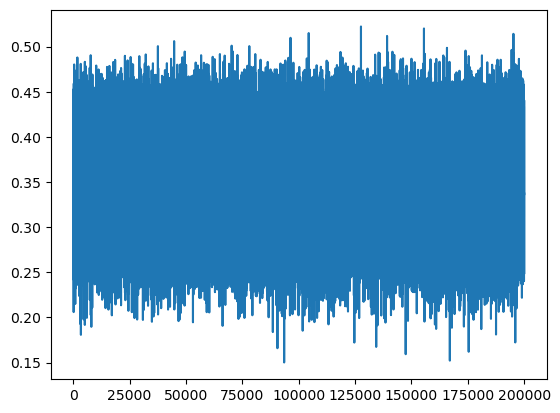

In [284]:
plt.plot(stepi, lossi)

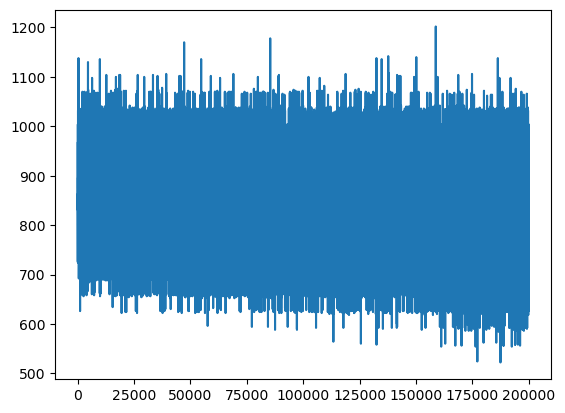

In [285]:
plt.plot(stepi, dead_neurons)

In [282]:
torch.sum((W1.grad == 0).int()).item()

132

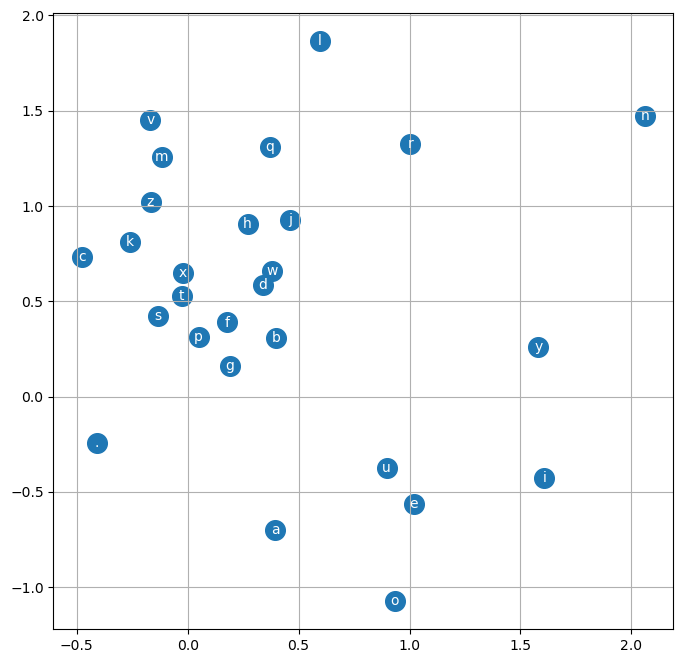

In [224]:

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [293]:
# Test it out

for _ in range(10):
    out = []
    idx = 0
    context = [0] * block_size
    while True:
        emd = C[context].view((1, block_size*m_dim))
        #z1 = F.leaky_relu(emd @ W1 + b1)
        z1 = F.relu(emd @ W1 + b1)
        z2 = F.softmax(z1 @ W2 + b2, dim=1)
        idx = torch.multinomial(z2, num_samples=1, replacement=True).item()
        out.append(itos[idx])
        context = context[1:] + [idx]
        if idx == 0:
            break

        # debug infinite loops...
        if len(out) > 10:
            break
    
    print(''.join(out))

jikanielasa
sakbifberya
eeo.
shainelle.
lamelrija.
mezeno.
maseleelysi
mila.
leah.
ezg.


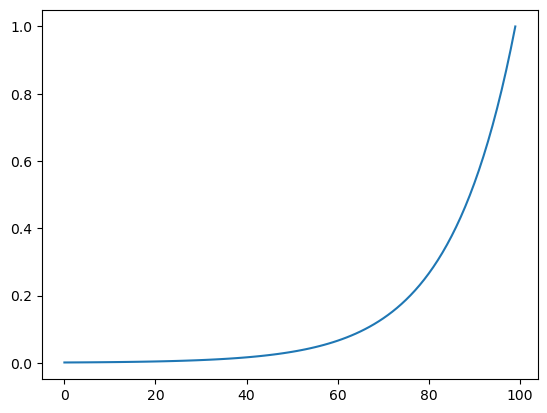

In [433]:
lre = torch.linspace(-3, 0, 100)
`
# Exponentially spaced learning rates, don't linearly space rates, linearly space exponents
plt.plot(10**lre)

# Using Pytorch for the model building instead of manual layer building

In [ ]:
#### Data prep

def build_dataset(in_words):
    # Create the dataset, where the inputs are a trigram context window -> outputs are the next character
    X, Y = [], []
    
    for w in in_words:
        w = w + '.'
        context = [0] * block_size
        for char in list(w):
            X.append(context)
            Y.append(stoi[char])
            context = context[1:] + [stoi[char]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [ ]:
#### Hyperparameters

# Num of features for each tri-gram embedding to learn
m_dim = 2

# possible characters, the vocabulary size, this isn't actually tuneable as its len(alphas) + 1 for delimiter
v = 27

# Number of neurons in hidden layer
h = 128

# This is n in the paper, the size of the "context" or look-back window
block_size = n = 3

In [324]:
embedding = nn.Embedding(v, m_dim)

idxs = torch.randint(0, X_train.shape[0], (batch_size,))
idx = X_train[idxs]
emb = embedding(idx)

print(idx.shape)
print(emb.shape)
print(emb.view(-1, 6).shape)

torch.Size([32, 3])
torch.Size([32, 3, 2])
torch.Size([32, 6])


In [339]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    # mps backend is slower than CPU for this model somehow...
    #device = "mps"
    pass

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(v, m_dim)
    self.linear_relu_stack = nn.Sequential(
        # W1/b1 hidden layer
        nn.Linear(block_size*m_dim, h),
        nn.ReLU(),
        # W2/b2 output layer
        nn.Linear(h, v)
        # Can return logits without normalization if using cross entropy loss
    )

  def forward(self, x):
    # C embedding matrix
    emb = self.embedding(x).view(-1, block_size*m_dim)
    logits = self.linear_relu_stack(emb)
    return logits

model = Model().to(device)

In [342]:
batch_size = 32

def train_loop(data, labels, model, loss_fn, optimizer):
  size = data.shape[0]
  model.train()
  for batch in range(200000):
    idxs = torch.randint(0, data.shape[0], (batch_size,))
    idx = data[idxs]

    pred = model(idx.to(device))
    loss = loss_fn(pred, labels[idxs].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 10000 == 0:
      loss, current = loss.item(), batch * batch_size
      print(f'loss: {loss} [{current} / {size}]')

def test_loop(data, labels, model, loss_fn):
  model.eval()
  num_batches = 200000
  size = num_batches * batch_size
  test_loss, correct = 0, 0

  with torch.no_grad():
    for batch in range(200000):
        idxs = torch.randint(0, data.shape[0], (batch_size,))
        idx = data[idxs]
        pred = model(idx.to(device))
        test_loss += loss_fn(pred, labels[idxs].to(device)).item()
        correct += (pred.argmax(1) == labels[idxs]).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f'test erorr -- acc: {100*correct}, avg loss: {test_loss}')


learning_rate = 0.1
epochs = 1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f'Epoch: {t+1}\n---------------------------------')
  train_loop(X_train, Y_train, model, loss_fn, optimizer)
  # Validation test
  test_loop(X_dev, Y_dev, model, loss_fn)

# Final test
test_loop(X_test, Y_test, model, loss_fn)

Epoch: 1
---------------------------------
test erorr -- acc: 28.920046875, avg loss: 2.2847751725935934
test erorr -- acc: 29.048593750000002, avg loss: 2.2736720143038034


In [376]:
# Test it out

for _ in range(10):
    out = []
    idx = 0
    context = torch.tensor([0] * block_size)
    while True:
        with torch.no_grad():
            pred = model(context)
            idx = torch.multinomial(F.softmax(pred), num_samples=1, replacement=True).item()
            out.append(itos[idx])
            context = torch.cat((context[1:], torch.tensor([idx])))
            if idx == 0:
                break
    
    print(''.join(out))

deivonnathia.
ka.
benindahadarli.
amahr.
arcsh.
brah.
raymomi.
lula.
boraila.
jerna.


/var/folders/3_/f7_6qhkx52b541cy70qyg15w0000gn/T/ipykernel_40098/1636299094.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  idx = torch.multinomial(F.softmax(pred), num_samples=1, replacement=True).item()


# My initial attempt at reproduction...

In [175]:
# Hyperparameters
m_dim = 2 # Num of features for each tri-gram embedding to learn
v = 27    # possible characters, the vocabulary size
h = 128    # Number of neurons in hidden layer

#################################################################
# From the paper, outputs are given by:
#     y = b + Wx + Utanh(d + Hx)
#
# b = the output biases
# d = hidden layer biases
# U = hidden to output weights
# H = hidden layer weights
#
# We omit W, which allows for a direct input weight to output connection, giving:
#     y = b + Utanh(d + Hx)
#################################################################

# C is the mapping of m-dimensional feature vectors for each of the characters.
C = torch.rand((v, m_dim))

# Hidden layer weights
# Paper says the size is (h x (block_size - 1)m_dim)
#H = torch.rand((h, (block_size-1)*m_dim), requires_grad=True)
# TODO: But I don't understand why the size is not (h x (block_size * m_dim)), lets go with that for now...
H = torch.rand((h, (block_size*m_dim)), requires_grad=True)

# Biases for the hidden layer
d = torch.rand((h, 1), requires_grad=True)

# Hidden to output weights
# Size (|V| x h)
U = torch.rand((v, h), requires_grad=True)

# Biases for output
b = torch.rand((v, 1), requires_grad=True)

In [176]:
# In order to multiple with H (size -> h x block_size*m_dim), our input matrix x
# needs to be of shape (block_size*m_dim x num_examples)
inputs = C[X].permute(1, 2, 0).reshape((block_size*m_dim, len(X)))
inputs.shape

torch.Size([6, 32])

In [178]:
inputs = C[X].permute(1, 2, 0).reshape((block_size*m_dim, len(X)))
Z = F.relu((H @ inputs) + d)

logits = (U @ Z) + b
# Why is this inf?
counts = logits.exp()

counts

tensor([[       inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf],
        [       inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf],
        [       inf,        inf,        inf,        inf,        inf,        inf,
                inf,        inf,        i